# Intronic variation - computational benchmark

This notebook refers to a evaluation of computational methods in the task of predicting deep intronic genetic variation, with a particular focus on variants that affect RNA Splicing. We took a great amount of time to gather and curate a dataset of pathogenic intronic variation located outside of canonical splice sites (extending our previous curation from vazDrago et al., 2017). Additionally, we carefully collected non-redundant variants from multiple recent studies that were shown to affect splicing outcome. Particularly, we were able to generate valuable subsets of variants that affect splicing differently (e.g. creating cryptic splice sites, affecting splicing regulatory elements, strenghning of existing cryptic sites, branchpoint disruption, etc). 

 After dataset collecion and model prediction annotation (for many of the methods we extracted predictions from existing pre-computed scores), the analyzes were performed with [VETA](https://github.com/PedroBarbosa/VETA), a simple standalone tool designed to benchmark prediction tools from VCF files. VETA's single requirement is that it just accepts VCFs annotated with [Ensembl VEP](https://www.ensembl.org/info/docs/tools/vep/script/index.html), because the `CSQ` INFO field is used to extract additional information about the variants being evaluated. 

In [1]:
#! pip install wand

In [2]:
import os
import shlex
import subprocess
from wand.image import Image as WImage
os.makedirs("out", exist_ok=True)

## **Clinvar v202204**

### *VETA evaluation*

#### *Analysis of Figure 1 and Supplementary Figure 1*

After filtering ClinVar dataset (check methods of the paper to see details), we generated a raw dataset for evaluation. We will  set `--do_intronic_analysis` to perform the evaluations using a bin-based approach. Optionally, if one wants to analyse donor and acceptor-associated variants separately, we could set the `--split_splice_sites` flag. Given that the datasets per bin are largely unbalanced (much more benign variants at all bins except at splice site locations), we will use the `weighted_F1` metric to score the tools.

* ### Raw dataset (without addressing circularity)

In [3]:
cmd = ["veta","benchmark","--out_dir","out/out_clinvar_raw",
    "--scopes_to_evaluate", "Splicing", "Conservation", "Whole_genome", 
    "--types_of_variant","snps",
    "--metric","weighted_F1",
    "--clinvar_stars","1s_l",
    "--config","data/clinvar/tools_config.txt",
    "--do_intronic_analysis",
    "--skip_heatmap",
    "data/clinvar/clinvar_intronic_raw_with_only_refeqID_consequence.vcf.gz"]

with open('out/log_clinvar_raw.txt', 'w') as f:
    subprocess.run(cmd,stderr=f, stdout=f, check=True)

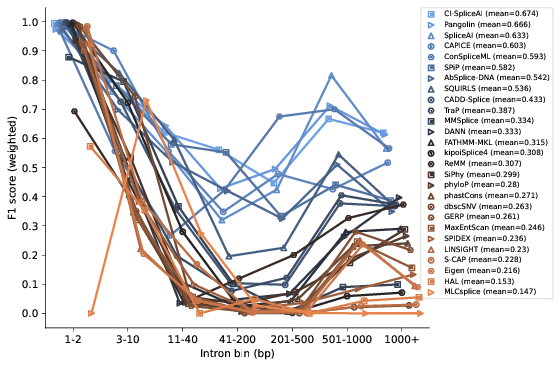

In [4]:
perf="out/out_clinvar_raw/1s_l/intron_analysis/all_bin_together/per_bin_all_weighted_F1.pdf"
img = WImage(filename=perf, resolution=75)
img

* ### Cleaner dataset (after addressing circularity)

From the tools with a minimally useful predictive power (defined as average weighted F1 score > 0.6), CAPICE was the only one trained with variant data. Hence, we wanted to control for type I circularity issues by excluding variants from the dataset that were used in CAPICE training. This lead to a exclusion of 14,189 variants. Now, we perform again evaluations on the remaining 53,600 variants.

In [5]:
! rm data/clinvar/1_circularity_cleaned/clinvar_intronic.vcf.gz.tsv
cmd = ["veta","benchmark","--out_dir","out/out_clinvar_all_tools",
    "--scopes_to_evaluate", "Splicing", "Conservation", "Whole_genome", 
    "--types_of_variant","snps",
    "--metric","weighted_F1",
    "--clinvar_stars","1s_l",
    "--config","data/clinvar/1_circularity_cleaned/tools_config.txt",
    "--do_intronic_analysis",
    "--skip_heatmap",
    "data/clinvar/1_circularity_cleaned/clinvar_intronic.vcf.gz"]

with open('out/log_clinvar_all_tools.txt', 'w') as f:
    subprocess.run(cmd,stderr=f, stdout=f, check=True)

As expected, the distribution of variants on each intronic bin is highly uneven:

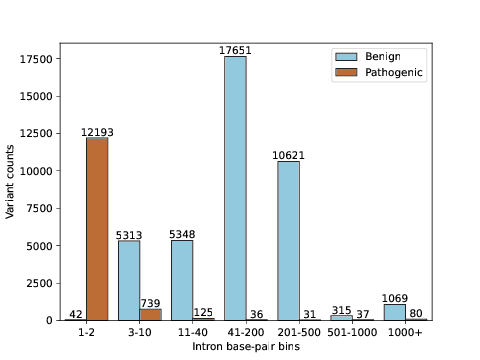

In [6]:
counts="out/out_clinvar_all_tools/1s_l/intron_analysis/variant_counts/counts_per_intronic_bin_all.pdf"
img = WImage(filename=counts, resolution=75)
img

Several tools have large amounts of missing data from the 11-40 intronic bin:

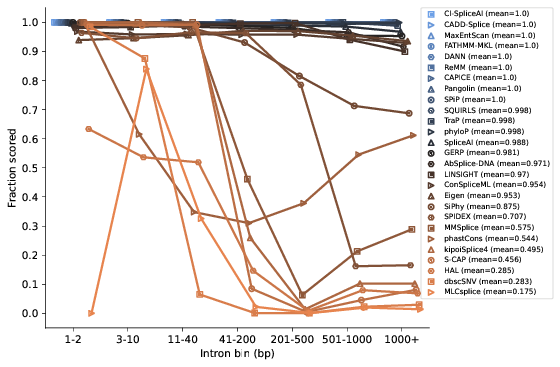

In [7]:
perf_per_bin="out/out_clinvar_all_tools/1s_l/intron_analysis/all_bin_together/per_bin_all_fraction_scored.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

* ### Removing tools with high fraction of missing data (keeping only tools with more than 90% coverage)

In [8]:
! rm data/clinvar/1_circularity/clinvar_intronic.vcf.gz.tsv
cmd = ["veta","benchmark","--out_dir","out/out_clinvar_highCoverageTools",
    "--scopes_to_evaluate", "Splicing", "Conservation", "Whole_genome",
    "--types_of_variant","snps",
    "--metric","weighted_F1",
    "--clinvar_stars","1s_l",
    "--config","data/clinvar/1_circularity_cleaned/tools_config_with_more_than_90percent_coverage.txt",
    "--do_intronic_analysis",
    "--skip_heatmap",
    "data/clinvar/1_circularity_cleaned/clinvar_intronic.vcf.gz"]

with open('out/log_clinvar_highCoverageTools.txt', 'w') as f:
    subprocess.run(cmd,stderr=f, stdout=f, check=True)

rm: cannot remove 'data/clinvar/1_circularity/clinvar_intronic.vcf.gz.tsv': No such file or directory


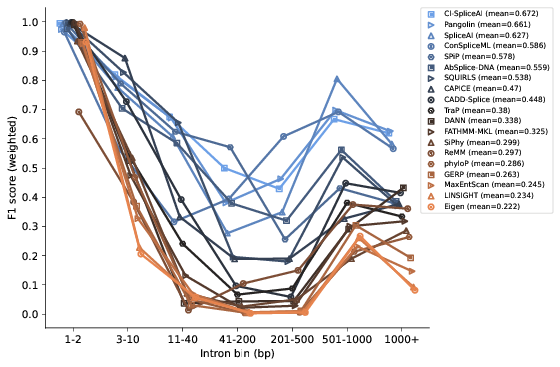

In [9]:
perf="out/out_clinvar_highCoverageTools/1s_l/intron_analysis/all_bin_together/per_bin_all_weighted_F1.pdf"
img = WImage(filename=perf, resolution=75)
img

* ### Performance tends to increase slightly at the 501-1000 and 1000+bp bins, probably due to the RefSeq transcript annotations used (variant may be exonic in other isoform of the associated gene). How does the tool performance change when evaluating variants that belong to different categories when analysing other transcripts ? 

#### Exonic variants

In [10]:
cmd = "veta benchmark --out_dir out/out_clinvar_plus_500_exonic \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    data/clinvar/2_plus_500/4_exonic.vcf.gz" 

args = shlex.split(cmd)

with open('out/log_clinvar_plus_500_exonic.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

#### Variants with only 1 consequence (hence, with the same transcript originally assigned)

In [11]:
cmd = "veta benchmark --out_dir out/out_clinvar_plus_500_intronic_1_conseq \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    data/clinvar/2_plus_500/4_one_conseq.vcf.gz" 
    
args = shlex.split(cmd)

with open('out/log_clinvar_plus_500_one_conseq.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True) 

#### Variants with only more than 1 consequence, but all of them with the same offset as the original consequence

In [12]:
cmd = "veta benchmark --out_dir out/out_clinvar_plus_500_intronic_moreThan1Tx_same_offset \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    data/clinvar/2_plus_500/4_moreThan1Tx_same_offset.vcf.gz"
    
args = shlex.split(cmd)

with open('out/log_clinvar_plus_500_moreThan1Tx_same_offset.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True) 

#### Variants with more than 1 consequence and having transcripts with a smaller variant offset

In [13]:
cmd = "veta benchmark --out_dir out/out_clinvar_plus_500_intronic_moreThan1Tx_smaller_offset \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    data/clinvar/2_plus_500/4_moreThan1Tx_smaller_offset.vcf.gz"
     
args = shlex.split(cmd)

with open('out/log_clinvar_plus_500_intronic_moreThan1Tx_smaller_offset.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True) 

 * ### How is the overall performance at deep intronic bins (>500bp) after excluding variants that are exonic and closer-to splice sites in other transcripts ?

In [14]:
!rm data/clinvar/2_plus_500/5_clinvar_excluding_some_plus500bp.vcf.gz.tsv
cmd = "veta benchmark --out_dir out/out_clinvar_excluding_exonic_and_closer_to_ss_all_tools \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --do_intronic_analysis \
    --clinvar_stars 1s_l \
    --config data/clinvar/2_plus_500/5_tools_config.txt \
    --skip_heatmap \
    data/clinvar/2_plus_500/5_clinvar_excluding_some_plus500bp.vcf.gz" 

args = shlex.split(cmd)

with open('out/log_clinvar_excluding_exonic_and_closer_to_ss_all_tools.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True) 

## **Manually curated dataset of pathogenic intronic variation** 

In [15]:
import os
import shlex
import subprocess
from wand.image import Image as WImage
os.makedirs("out", exist_ok=True)

In [16]:
from wand.image import Image as WImage

#### *Analysis for Figure 2 and Supplementary Figure 2*

Here, we run VETA on a dataset of manually curated deep intronic variants that cause disease via splicing abnormalities. Using `--do_threshold` and `--bootstrap` flags, we will study how fit are the reference thresholds of each tool to predict variants deep in the introns.

In [17]:
cmd ="veta benchmark --out_dir out/out_splicing_pathogenic_manual_curation \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_pathogenic_manual_curation/tools_config.txt \
    --top_vep_consequence smallest_offset \
    data/splicing_pathogenic_manual_curation/ \
    --do_threshold_analysis \
    --bootstrapping"
args = shlex.split(cmd)

with open('out/log_splicing_pathogenic_manual_curation.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True) 

Overall performance using the reference thresholds is modest, except for Pangolin, SpliceAI and PDIVAS:

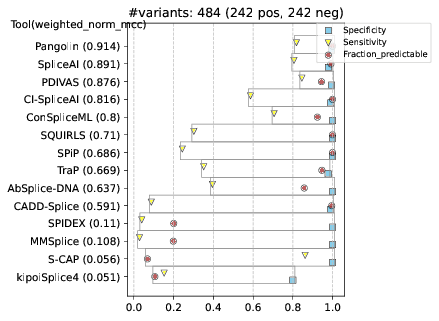

In [18]:
overall_perf="out/out_splicing_pathogenic_manual_curation/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

Overall performance using ROC curves reveals better results overall, with multiple tools with auROC > 0.9:

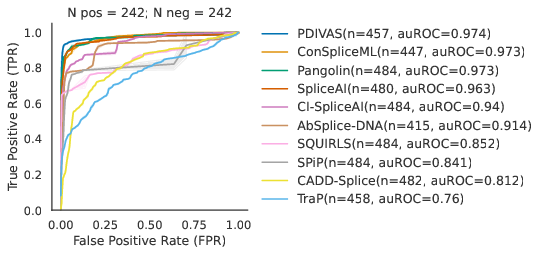

In [19]:
overall_perf="out/out_splicing_pathogenic_manual_curation/tools_benchmark/all_types/roc_analysis/ROC_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

By running again a standard analysis using the new, adjusted thresholds, performance increases nicely.

In [20]:
! cp out/out_splicing_pathogenic_manual_curation/thresholds_analysis/new_configs/new_config_all_f0.5.txt data/splicing_pathogenic_manual_curation/
! cp out/out_splicing_pathogenic_manual_curation/thresholds_analysis/new_configs/new_config_all_f1.txt data/splicing_pathogenic_manual_curation/
! cp out/out_splicing_pathogenic_manual_curation/thresholds_analysis/new_configs/new_config_all_f1.5.txt data/splicing_pathogenic_manual_curation/

cmd = "veta benchmark --out_dir out/out_splicing_pathogenic_manual_curation_adj_thresholds \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_pathogenic_manual_curation/new_config_all_f1.txt \
    --top_vep_consequence smallest_offset \
    data/splicing_pathogenic_manual_curation" 

args = shlex.split(cmd)

with open('out/log_splicing_pathogenic_manual_curation_adjusted_thresh.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True) 

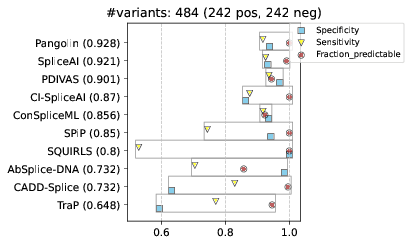

In [21]:
overall_perf="out/out_splicing_pathogenic_manual_curation_adj_thresholds/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

### **Pseudoexon activation vs Exon enlongation**

We now run benchmarking for the two subsets of variants separately, and then evaluate them using the R script `2_manual_curated_dataset_Elong_vs_PseudoExon.R` under the scripts directory.

In [22]:
cmd = "veta benchmark --out_dir out/out_splicing_pathogenic_manual_curation_pe_only \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --top_vep_consequence smallest_offset \
    --config data/splicing_pathogenic_manual_curation/new_config_all_f1.txt \
    data/splicing_pathogenic_manual_curation/pseudoexon_activation/"
 
args = shlex.split(cmd)

with open('out/log_out_splicing_pathogenic_manual_curation_pe_only.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)   

In [23]:
cmd = "veta benchmark --out_dir out/out_splicing_pathogenic_manual_curation_pir_only \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --top_vep_consequence smallest_offset \
    --config data/splicing_pathogenic_manual_curation/new_config_all_f1.txt  \
    data/splicing_pathogenic_manual_curation/partial_intron_retention/" 
    
args = shlex.split(cmd)

with open('out/log_out_splicing_pathogenic_manual_curation_pir_only.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

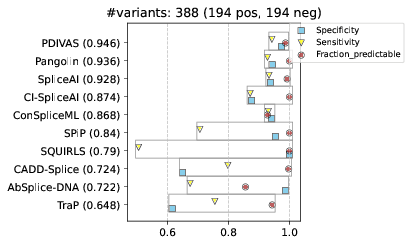

In [24]:
! cp out/out_splicing_pathogenic_manual_curation_pe_only/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_pathogenic_manual_curation/pseudoexon_activation
overall_perf="out/out_splicing_pathogenic_manual_curation_pe_only/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

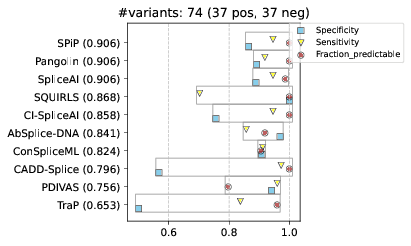

In [25]:
! cp out/out_splicing_pathogenic_manual_curation_pir_only/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_pathogenic_manual_curation/partial_intron_retention
overall_perf="out/out_splicing_pathogenic_manual_curation_pir_only/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

# **Variants affecting RNA splicing**

#### *Analysis for Figure 3, Supplementary Figure 3 and Supplementary Figure 4*

This section of the analysis focuses on the comparison of prediction tools to identify splicing-altering variants that do so by different mechanisms. Some alter the branchpoint signal in the intron upstream, others create a new splice site that trigger pseudoexon inclusion, others activate existing cryptic splice sites that lead to exon elongation/partial intron retention. Several datasets were integrated and curated for this study:

* [VazDrago 2017](https://pubmed.ncbi.nlm.nih.gov/28497172/) and PedroBarbosa 2022 (N splicing altering used=221): Our own curated list of disease-causing variants by means of alteration of RNA splicing. Used in the previous section, but here they are decomposed in different categories. 
* [Keegan 2022](https://pubmed.ncbi.nlm.nih.gov/35140743/) (N splicing altering used=143): Comprehensive curation of variants that drive cryptic splicing, not all of them causing disease. Some overlap with our own curation, but many variants are unique. Large indels and coding variants were discarded. 
* [Petersen 2021](https://onlinelibrary.wiley.com/doi/full/10.1002/humu.24306) (N splicing altering used=10): Comprehensive analysis of pseudoexon activation caused by intronic variants that do not create splice sites. Most of them create/repress/alter splicing regulatory elements within the generated pseudoexon. Many variants are already present in the two previous curation, hence the reduced final number of unique variants used.
* [Tubeuf 2020](https://onlinelibrary.wiley.com/doi/full/10.1002/humu.24091) (N splicing altering used=3): Benchmark of user-friendly tools with variants that induce alterations in splicing regulatory elements. Most of variants collected are exonic, therefore we removed them. For a small set of intronic variants that induce pseudoexon activation (N=13), we selected 3 that are not present in any of the previous datasets collected.
* [Jung 2021](https://pubmed.ncbi.nlm.nih.gov/33420369/) (N splicing altering used=231): Comprehensive caracterization of intronic mis-splicing in human cancers. Authors developed a method to caracterize intronic variation and its effect of splicing based on RNA-seq data. 
* [Leman 2020](https://pubmed.ncbi.nlm.nih.gov/31992191/) (N splicing altering used=31): Benchmark of bioinformatics tools to predict branchpoints (BP) as well as the impact of splicing variants occurring in the BP area.
* [Zhang 2022](https://pubmed.ncbi.nlm.nih.gov/36306325/) (N splicing altering used=16): Genome-wide analysis of human branchpoints and development of a tool to score BP-associated variants.
* [Moles-Fernández 2021](https://pubmed.ncbi.nlm.nih.gov/34283047/) (N splicing altering used=15; N splicing neutral used=98): Evaluation of the impact of splicing regulatory elements in the identification of variants in hereditary breast/ovarian cancer genes. Datasets collected from manual literature search as well as from other studies.
* [Adamson 2018](https://pubmed.ncbi.nlm.nih.gov/29859120/) (N splicing neutral used=277): A MPRA (Vex-seq) to test the impact of 2059 variants in RNA-splicing spanning 110 alternative exons. Variants with no splicing effect (dPSI < 1) were selected, yielding a balanced number of exonic (to be compared with the splicing-altering variants ocurring within activated pseudoexons) and intronic variants.
* [Cheung 2019](https://pubmed.ncbi.nlm.nih.gov/30503770/) (N splicing neutral used=109): Multiplexed functional assay (MFASS) that assayed the splicing effect of 27,733 variants from ExAC. Variants with no splicing effect (dPSI < 2 in both replicates) were selected. 
  
Here, we evaluate the performance of tools in different splicing regions: branchpoint variants, acceptor associated, exonic-like, new splice donor and donor downstream. Within each region (except for Branchpoint variants that were all analyzed together in a single analysis), we evaluate separately two major groups: variants leading to pseudoexon actvations and variants triggering partial intron retention.

To group variants from different studies into each splicing category, we run the R script `scripts/3_splicing_associated_generate_datasets.R` to generate the variant positions corresponding to each category. Then, the following commands were run to generate category-specific VCF files (which are commented, because the final files are already in the repo):

In [26]:
# #Branchpoint
# !zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/branchpoint_associated/position_positive.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/branchpoint_associated/deleterious.vcf.gz
# !zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/branchpoint_associated/position_negative.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/branchpoint_associated/neutral.vcf.gz

# # PE ACCEPTOR ASSOCIATED
# !zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/pseudoexon_activation/acceptor_associated/position_positive.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/pseudoexon_activation/acceptor_associated/deleterious.vcf.gz
# !zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/pseudoexon_activation/acceptor_associated/position_negative.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/pseudoexon_activation/acceptor_associated/neutral.vcf.gz

# # PE EXONIC-LIKE
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/pseudoexon_activation/exonic_like/position_positive.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/pseudoexon_activation/exonic_like/deleterious.vcf.gz
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/pseudoexon_activation/exonic_like/position_negative.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/pseudoexon_activation/exonic_like/neutral.vcf.gz

# # PE NEW DONOR
#! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/pseudoexon_activation/new_donor/position_positive.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/pseudoexon_activation/new_donor/deleterious.vcf.gz
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/pseudoexon_activation/new_donor/position_negative.txt -| cut -f1-8 | bgzip > data/splicing_altering/per_category/pseudoexon_activation/new_donor/neutral.vcf.gz

# # PE DONOR DOWNSTREAM
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/pseudoexon_activation/donor_downstream/position_positive.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/pseudoexon_activation/donor_downstream/deleterious.vcf.gz
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/pseudoexon_activation/donor_downstream/position_negative.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/pseudoexon_activation/donor_downstream/neutral.vcf.gz

# # PARTIAL IR ACCEPTOR ASSOCIATED
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/partial_intron_retention/acceptor_associated/position_positive.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/partial_intron_retention/acceptor_associated/deleterious.vcf.gz
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/partial_intron_retention/acceptor_associated/position_negative.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/partial_intron_retention/acceptor_associated/neutral.vcf.gz

# # PARTIAL IR EXONIC-LIKE
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/partial_intron_retention/exonic_like/position_positive.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/partial_intron_retention/exonic_like/deleterious.vcf.gz
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/partial_intron_retention/exonic_like/position_negative.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/partial_intron_retention/exonic_like/neutral.vcf.gz

# # PARTIAL IR NEW DONOR
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/partial_intron_retention/new_donor/position_positive.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/partial_intron_retention/new_donor/deleterious.vcf.gz
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/partial_intron_retention/new_donor/position_negative.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/partial_intron_retention/new_donor/neutral.vcf.gz

# # PARTIAL IR DONOR DOWNSTREAM
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/partial_intron_retention/donor_downstream/position_positive.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/partial_intron_retention/donor_downstream/deleterious.vcf.gz
# ! zcat < data/splicing_altering/all_variants_hg19.vcf.gz | awk -vOFS='\t' '($0 ~ /^#/ || (FNR!=NR && $2 in a)) {print $0} FNR==NR{a[$1];next}' data/splicing_altering/per_category/partial_intron_retention/donor_downstream/position_negative.txt - | cut -f1-8 | bgzip > data/splicing_altering/per_category/partial_intron_retention/donor_downstream/neutral.vcf.gz

In [27]:
from wand.image import Image as WImage
import os
import shlex
import subprocess
from wand.image import Image as WImage
os.makedirs("out", exist_ok=True)

## **1) Branchpoint-associated variants**

This dataset is composed by 82 intronic variants that affect the branchpoint signal (located -18 to -44bp upstream of an annotated splicing acceptor), usually leading to intron retention and/or exon skipping. There are few exceptions that actually do the opposite, by creating a new branchpoint and leading to partial intron retention and/or pseudoexon activations. The neutral dataset (N=95) is composed of experimentally validated variants that between the -18 and -44 bp upstream of existing splicing acceptors, and did not lead to any splicing change.

For this analyis, we additionally incorporate branchpoint-specific tools such as BPP, labranchoR, SVM BP finder and BPHunter. Additionally, we tested IntSplice2 that are targeted to make predictions in these regions. The steps to generate VCFs with the variant effect scores for these tools (except for labRanchoR that was run using kipoi, and VETA has internal functions to automatically process its ouput) can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [28]:
cmd = "veta benchmark --out_dir out/out_branchpoint \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/branchpoint_associated/tools_config.txt \
    data/splicing_altering/per_category/branchpoint_associated/" 

args = shlex.split(cmd)

with open('out/log_branchpoint.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

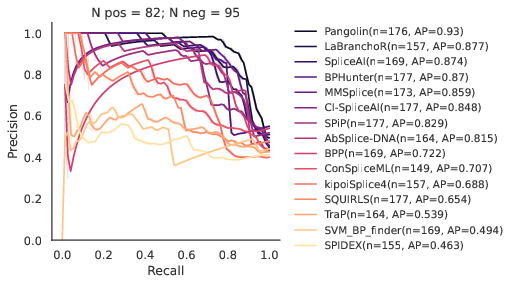

In [29]:
! cp out/out_branchpoint/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/branchpoint_associated/
perf="out/out_branchpoint/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

## **2) Variants that trigger pseudoexon inclusion**

This dataset is composed by deep intronic variants that activate the expression of pseudoexons. We analyze four different subsets that activate this sequences by different mechanisms.

### **A) Variants that are associated with splicing acceptors**

Dataset composed by 89 deep intronic variants that trigger pseudoexon inclusion by the creation of a new splicing acceptor, or by strenghthening a cryptic one, usually affecting a cryptic polypirimidine tract (positive set). The neutral dataset was not straightforward to generate, since it is hard to gather experimentally validated variants that "create" new splice acceptors and do not lead to any splicing switch. Therefore, to mimic as close as possible the positive set, we looked for common deep intronic SNVs (> 5\% AF) protein-coding variants in gnomAD that generate the most common 5-mer acceptor C**AG**GT in the human genome ([Sibley et al., 2016](https://www.nature.com/articles/nrg.2016.46)). From the obtained set, we randomly selected 64 variants (same as the positive set that create a new splice acceptor) to serve the control set. We also gathered variants upstream of splicing acceptors to match with the set of positive variants that strengthen existing cryptic splice acceptors. Hence, merging all these sets we generated 109 control variants.

For this analyis, we additionally incorporate some deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover andç Spliceator. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [30]:
cmd = "veta benchmark --out_dir out/out_pe_acceptor_associated \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/pseudoexon_activation/acceptor_associated/tools_config.txt \
    data/splicing_altering/per_category/pseudoexon_activation/acceptor_associated" 

args = shlex.split(cmd)

with open('out/log_pe_acceptor_associated.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

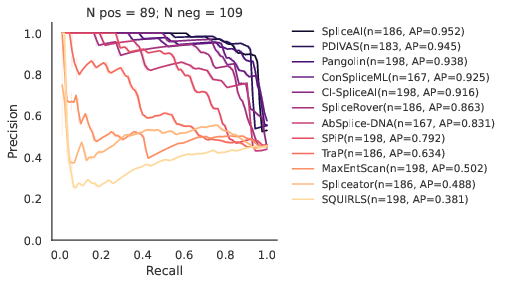

In [31]:
! cp out/out_pe_acceptor_associated/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/pseudoexon_activation/acceptor_associated
perf="out/out_pe_acceptor_associated/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **B) Variants that potentially affect splicing regulatory elements (Exonic-like category)**

This dataset is composed by 78 intronic variants that occur within the pseudoexon boundaries and change normal splicing by likely affecting SREs (positive set). The neutral dataset (variants that do not change splicing, negative set) refers to a set of exonic variants (to resemble as much as possible the positive set) that were proven to not affect splicing. This set comes exclusively from Adamson_Vex_seq and 84 variants were randomly selected to balance with the positive set.

For this analysis, we additionally incorporate user-friendly tools such as ESEfinder, HEXplorer and ESRseq scores originated from the QUEPASA method. The steps to generate VCFs with the variant effect scores of each of these method can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [32]:
cmd = "veta benchmark --out_dir out/out_pe_exonic_like \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/pseudoexon_activation/exonic_like/tools_config.txt \
    data/splicing_altering/per_category/pseudoexon_activation/exonic_like" 
    
args = shlex.split(cmd)

with open('out/log_pe_exonic_like.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

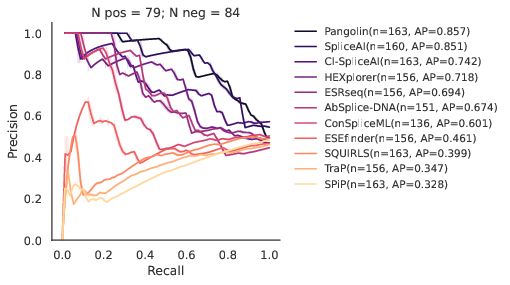

In [33]:
! cp out/out_pe_exonic_like/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/pseudoexon_activation/exonic_like
perf="out/out_pe_exonic_like/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

Let's further inspect the variant positions that were not captured by SpliceAI using pre-computed scores, so that we can manually test these variants using SpliceAI lookup database (with larger max distance size). We run VETA in the interrogate mode on all exonic_like splicing altering variants (including those on the partial intron retention group) to check which variants were missed by SpliceAI using the optimized threshold for deep intronic regions (0.05):

In [34]:
cmd = "veta interrogate --out_dir out/out_inspect_SpliceAI_exonic_like \
    --types_of_variant all_types \
    --plot_these_tools SpliceAI \
    --top_vep_consequence smallest_offset \
    --config data/splicing_altering/per_category/pseudoexon_activation/exonic_like/precomputed_vs_spliceAI_lookup/tools_config.txt \
    data/splicing_altering/per_category/pseudoexon_activation/exonic_like/precomputed_vs_spliceAI_lookup/all_exonic_like_deleterious.vcf.gz"

args = shlex.split(cmd)

with open('out/log_inspect_spliceAI_exonic_like.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

In [35]:
! cp out/out_inspect_SpliceAI_exonic_like/all_types/individual_predictions_raw_scores.tsv data/splicing_altering/per_category/pseudoexon_activation/exonic_like/precomputed_vs_spliceAI_lookup
! cp out/out_inspect_SpliceAI_exonic_like/all_types/individual_predictions.tsv data/splicing_altering/per_category/pseudoexon_activation/exonic_like/precomputed_vs_spliceAI_lookup
! awk ' $9 < 0.05 ' data/splicing_altering/per_category/pseudoexon_activation/exonic_like/precomputed_vs_spliceAI_lookup/individual_predictions_raw_scores.tsv | cut -f1-4 | sed 's/\t/-/g' > data/splicing_altering/per_category/pseudoexon_activation/exonic_like/precomputed_vs_spliceAI_lookup/lookup_input.txt

### **C) Variants that create a new splicing donor**

Dataset composed by 161 deep intronic variants that trigger pseudoexon inclusion by the creation of a new splicing donor (positive set). A control dataset (N=197) was generated as for the new splice acceptor variants. To mimic as close as possible the positive set, we looked for common deep intronic SNVs (> 5\% AF) protein-coding variants in gnomAD that generate the most common 6-mer donor G**GT**AAG in the human genome ([Sibley et al., 2016](https://www.nature.com/articles/nrg.2016.46)). From the obtained set, we randomly selected 161 variants to serve as negative set, whereas the remaining one (N=36) will serve as controls for an upcoming section (new donor variants that trigger partial intron retention).

For this analyis, we additionally incorporate some deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [36]:
cmd = " veta benchmark --out_dir out/out_pe_new_donor \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/pseudoexon_activation/new_donor/tools_config.txt \
    data/splicing_altering/per_category/pseudoexon_activation/new_donor/" 
    
args = shlex.split(cmd)

with open('out/log_pe_new_donor.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

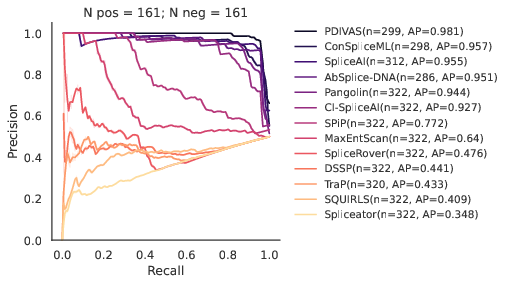

In [37]:
! cp out/out_pe_new_donor/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/pseudoexon_activation/new_donor
perf="out/out_pe_new_donor/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **D) Variants that enhance cryptic splice donors (ocurring downstream of them)**

Dataset composed by 91 deep intronic variants that trigger pseudoexon inclusion by activation of a near-by upstream splicing donor (positive set). A control dataset (N=98) was generated by selecting donor-associated at >20bp from the upstream donor.

For this analyis, we additionally incorporate some additionally deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [38]:
cmd = "veta benchmark --out_dir out/out_pe_donor_downstream \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/pseudoexon_activation/donor_downstream/tools_config.txt \
    data/splicing_altering/per_category/pseudoexon_activation/donor_downstream/" 

args = shlex.split(cmd)

with open('out/log_pe_donor_downstream.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

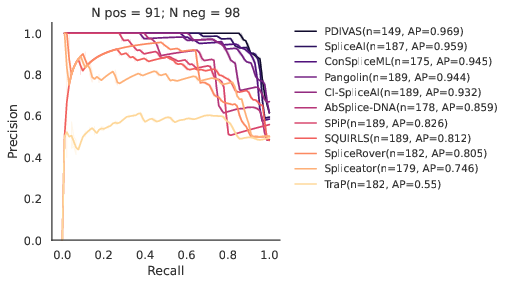

In [39]:
! cp out/out_pe_donor_downstream/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/pseudoexon_activation/donor_downstream
perf="out/out_pe_donor_downstream/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

## **2) Variants leading to partial intron retention (exon elongation)**

This dataset is composed by intronic variants that partial intron retention. We analyze four different subsets that lead to this functional outcome.

### **A) Variants that are associated with splicing acceptors**

Dataset composed by 46 intronic variants that trigger exon elongation by the creation of a new splicing acceptor, or by strenghthening a cryptic one, usually affecting a cryptic polypirimidine tract (positive set). The control dataset (N=59) was generated based on the proximity of variants to annotated exons located between -3 and -18 and -44 and 150bp upstream of the splice acceptors.

Just like before (for pseudoexon-activating variants), we incorporate some deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover and Spliceator. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [40]:
cmd = "veta benchmark --out_dir out/out_partial_ir_acceptor_associated \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/partial_intron_retention/acceptor_associated/tools_config.txt \
    data/splicing_altering/per_category/partial_intron_retention/acceptor_associated" 

args = shlex.split(cmd)

with open('out/log_partial_ir_acceptor_associated.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

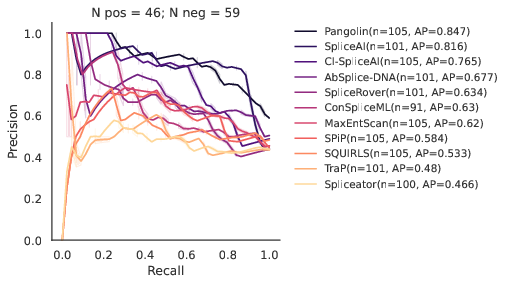

In [41]:
! cp out/out_partial_ir_acceptor_associated/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/partial_intron_retention/acceptor_associated/
perf="out/out_partial_ir_acceptor_associated/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **B) Variants that affect splicing regulatory elements (Exonic-like category)**

This subset contains intronic variants that trigger partial intron retention, being consired exonic in the new aberrant product. It is composed by 32 that probably affect SREs and enhance the usage of either a downstream donor or upstream acceptor (positive set). The control dataset (variants that do not change splicing, negative set) refers to a set of exonic variants (to resemble as much as possible the positive set) that were tested to not affect splicing. This set comes exclusively from Adamson_Vex_seq 35 variants were randomly selected to balance with the positive set.

For this analysis, we additionally incorporate user-friendly tools such as ESEfinder, HEXplorer and ESRseq scores originated from the QUEPASA method. The steps to generate VCFs with the variant effect scores of each of these method can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [42]:
cmd = "veta benchmark --out_dir out/out_partial_ir_exonic_like \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/partial_intron_retention/exonic_like/tools_config.txt \
    data/splicing_altering/per_category/partial_intron_retention/exonic_like" 
    
args = shlex.split(cmd)

with open('out/log_partial_ir_exonic_like.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

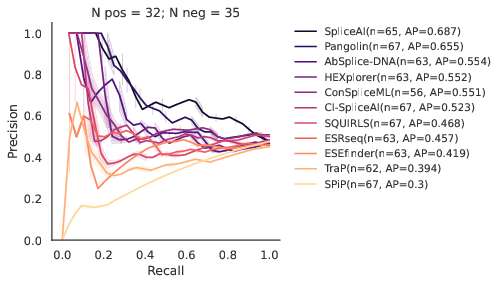

In [43]:
! cp out/out_partial_ir_exonic_like/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/partial_intron_retention/exonic_like/
perf="out/out_partial_ir_exonic_like/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

Just like before, as done with pseudoexon-activating variants, we checked the variant positions that were not captured by SpliceAI using pre-computed scores to then run again SpliceAI using SpliceAI lookup.

### **C) Variants that create a new splicing donor**

Dataset composed by 36 intronic variants that create a new splice donor and lead to exon elongation/partial intron retention (positive set). A control dataset (N=36) was generated by randomly selecting 36 variants from the set of 197 gnomAD variants that create a new splice donor motif.

As before, we also incorporate deep learning methods that predict splice sites. They are SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [44]:
cmd = "veta benchmark --out_dir out/out_partial_ir_new_donor \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/partial_intron_retention/new_donor/tools_config.txt \
    data/splicing_altering/per_category/partial_intron_retention/new_donor/" 

args = shlex.split(cmd)

with open('out/log_partial_ir_new_donor.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)    

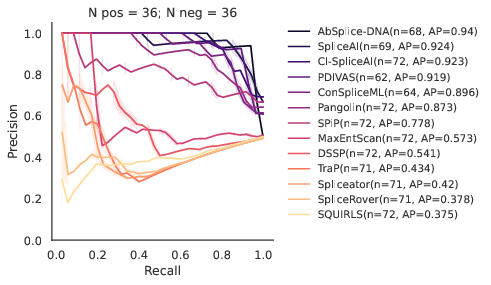

In [45]:
! cp out/out_partial_ir_new_donor/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/partial_intron_retention/new_donor/
perf="out/out_partial_ir_new_donor/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **D) Variants that enhance cryptic splice donors (ocurring downstream of them)**

Dataset composed by 55 intronic variants that trigger partial intron retention by enhancing the usage of an upstream cryptic splicing donor (positive set). A neutral dataset (N=68) was generated by looking at intronic variants located at <20bp from the upstream splice donor that were experimentally tested to have no effect on splicing of the upstream exon.

For this analyis, we also included SpliceRover and Spliceator. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [46]:
cmd = "veta benchmark --out_dir out/out_partial_ir_donor_downstream \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/partial_intron_retention/donor_downstream/tools_config.txt \
    data/splicing_altering/per_category/partial_intron_retention/donor_downstream/" 

args = shlex.split(cmd)

with open('out/log_partial_ir_donor_downstream.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

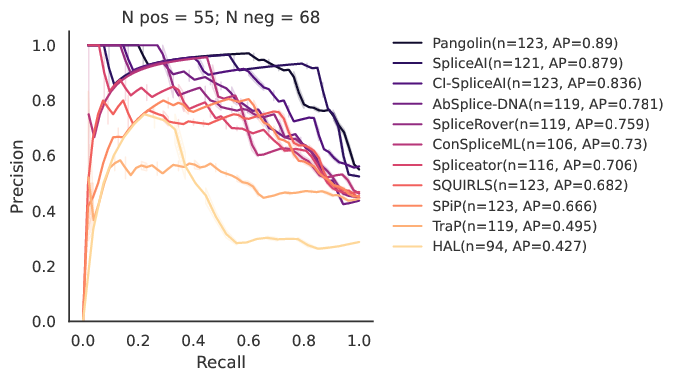

In [47]:
! cp out/out_partial_ir_donor_downstream/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/partial_intron_retention/donor_downstream/
perf="out/out_partial_ir_donor_downstream/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=100)
img

# **Evaluating interpretability (of SPiP, SQUIRLS and SpliceVault) and tissue-specificity of AbSplice-DNA**

#### *Analysis for Figure 4, Supplementary Figure 5 and Supplementary Figure 6*

### Interpretability

We will inspect whether tools that take interpretability into account provide accurate hints when predicting correctly a splicing defect. First, we will check which variants SQUIRLS and SPiP predict correctly in the splicing pathogenic dataset.

In [48]:
cmd = "veta interrogate --out_dir out/out_inspect_interpretability \
    --types_of_variant all_types \
    --metric weighted_accuracy \
    --label Pathogenic \
    --plot_these_tools SQUIRLS SPiP \
    --top_vep_consequence smallest_offset \
    --config data/splicing_pathogenic_manual_curation/2_interpretability/tools_config.txt \
    data/splicing_pathogenic_manual_curation/2_interpretability/pathogenic_with_full_info.vcf.gz" 

args = shlex.split(cmd)

with open('out/log_inspect_interpretability.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

We ran again SQUIRLS for the subset of variants predicted correctly by generating output in HTML. Then, we manually curated the interpretations provided by SQUIRLS. For SpliceVault, we manually looked at the SpliceVault portal for each variant that the framework may capture its molecular effect (pseudoexon activation variants were excluded). 

To aggregate the results, we run the R script `6_evaluate_interpretability.R` within the `scripts` directory. This script automatically processed SPiP, SQUIRLS and SpliceVault interpretations to generate final plots. 

### AbSplice-DNA

In addition, we aimed to study how well AbSplice-DNA predicts tissue specificity. From the manually curated dataset (ours plus VazDrago et al.,2017) of pathogenic variants, we collected the closest GTEx tissues that the disease affects, according to the human phenotype ontology. Our goal was to evaluate whether AbSplice-DNA gives higher scores for those tissues where the variant is relevant. We check which variants AbSplice-DNA predicts correctly with:

In [49]:
cmd = "veta interrogate --out_dir out/out_inspect_tissue_specificity \
    --types_of_variant all_types \
    --metric weighted_accuracy \
    --label Pathogenic \
    --plot_these_tools AbSplice-DNA \
    --top_vep_consequence smallest_offset \
    --config data/splicing_pathogenic_manual_curation/3_tissue_specificity/tools_config.txt \
    data/splicing_pathogenic_manual_curation/pathogenic.vcf.gz"

args = shlex.split(cmd)

with open('out/log_inspect_tissue_specificity.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)